# Reprojecting/resampling data

As mentioned in the introduction, the Astropy project consists not just of the core astropy package but also of coordinated packages (which are managed by the project) and affiliated packages (which adhere to the coding, testing, and documentation standards of the project but are not managed by the project). All the functionality we've seen in previous tutorials was in the core package, but we now look at one of the coordinated packages: [reproject](https://reproject.readthedocs.io/en/stable/). The aim of this package is to make it possible to reproject/resample data from one WCS to another. This is useful when trying to compare images pixel to pixel, make color composite images, or mosaics.


<section class="objectives panel panel-warning">
<div class="panel-heading">
<h2><span class="fa fa-certificate"></span> Objectives</h2>
</div>


<div class="panel-body">

<ul>
<li>Reproject an image from one WCS to another</li>
<li>Understand the different types of reprojection and accuracy implications</li>
</ul>

</div>

</section>


## Documentation

This notebook only shows a subset of the functionality in `reproject`. For more information about the features presented below as well as other available features, you can read the
[reproject](https://reproject.readthedocs.io/en/stable/) documentation.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rc('image', origin='lower')
plt.rc('figure', figsize=(10, 6))

In [2]:
!pip install reproject -U

  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\ssbch\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe' 'C:\Users\ssbch\AppData\Local\Temp\pip-standalone-pip-6s9t5gt2\__env_pip__.zip\pip' install --ignore-installed --no-user --prefix 'C:\Users\ssbch\AppData\Local\Temp\pip-build-env-ld6ea33f\overlay' --no-warn-script-location --no-binary :none: --only-binary :none: -i https://pypi.org/simple -- setuptools setuptools_scm wheel extension-helpers oldest-supported-numpy cython==0.29.14
       cwd: None
  Complete output (387 lines):
    Using cached setuptools_scm-6.0.1-py3-none-any.whl (27 kB)
    Using cached wheel-0.36.2-py2.py3-none-any.whl (35 kB)
    Using cached extension_helpers-0.1-py2.py3-none-any.whl (20 kB)
    Using cached oldest_supported_numpy-0.8-py3-none-any.whl (3.7 kB)
    Using cached Cython-0.29.14.tar.gz (2.1 MB)
    Using cached numpy-1.19.3-cp39-cp39-win_amd64.whl (13.3 MB)
  Using legacy 'setup.p


  Using cached reproject-0.7.1.tar.gz (770 kB)
  Installing build dependencies: started
  Installing build dependencies: still running...
  Installing build dependencies: finished with status 'error'
  Using cached reproject-0.7.tar.gz (770 kB)
  Installing build dependencies: started
  Installing build dependencies: still running...
  Installing build dependencies: finished with status 'error'
  Using cached reproject-0.6.tar.gz (827 kB)
  Installing build dependencies: started
  Installing build dependencies: still running...
  Installing build dependencies: still running...
  Installing build dependencies: finished with status 'error'
  Using cached reproject-0.5.1.tar.gz (663 kB)
  Using cached reproject-0.5.tar.gz (660 kB)


      creating build\lib.win-amd64-3.9\Cython\Build\Tests
      copying Cython\Build\Tests\TestCyCache.py -> build\lib.win-amd64-3.9\Cython\Build\Tests
      copying Cython\Build\Tests\TestInline.py -> build\lib.win-amd64-3.9\Cython\Build\Tests
      copying Cython\Build\Tests\TestIpythonMagic.py -> build\lib.win-amd64-3.9\Cython\Build\Tests
      copying Cython\Build\Tests\TestStripLiterals.py -> build\lib.win-amd64-3.9\Cython\Build\Tests
      copying Cython\Build\Tests\__init__.py -> build\lib.win-amd64-3.9\Cython\Build\Tests
      creating build\lib.win-amd64-3.9\Cython\Compiler\Tests
      copying Cython\Compiler\Tests\TestBuffer.py -> build\lib.win-amd64-3.9\Cython\Compiler\Tests
      copying Cython\Compiler\Tests\TestCmdLine.py -> build\lib.win-amd64-3.9\Cython\Compiler\Tests
      copying Cython\Compiler\Tests\TestFlowControl.py -> build\lib.win-amd64-3.9\Cython\Compiler\Tests
      copying Cython\Compiler\Tests\TestGrammar.py -> build\lib.win-amd64-3.9\Cython\Compiler\Tests
 

## Simple reprojection

We start off by loading the two images of the LMC that we've been working with so far - the source density map from GAIA, and the IRAS 100µm map:

In [3]:
from astropy.io import fits
hdu_gaia = fits.open('data/LMCDensFits1k.fits')[0]
hdu_iras = fits.open('data/ISSA_100_LMC.fits')[0]

and we extract the WCS from the headers:

In [4]:
from astropy.wcs import WCS
wcs_gaia = WCS(hdu_gaia.header)
wcs_iras = WCS(hdu_iras.header)

As we can see, the GAIA image is defined in Galactic coordinates:

In [5]:
wcs_gaia

WCS Keywords

Number of WCS axes: 2
CTYPE : 'GLON-SIN'  'GLAT-SIN'  
CRVAL : 280.319239  -32.8378823  
CRPIX : 500.0  375.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.014  0.014  
NAXIS : 1000  750

while the IRAS map is defined in equatorial coordinates:

In [6]:
wcs_iras

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 78.0  -70.0  
CRPIX : 250.0  250.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.025  0.025  
NAXIS : 500  500

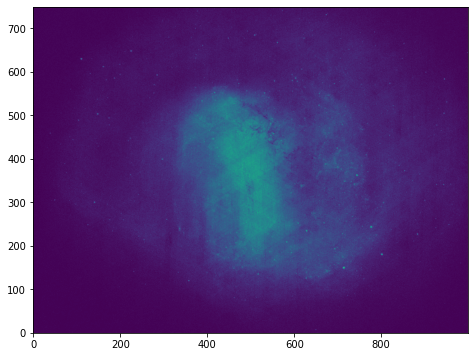

In [7]:
plt.imshow(hdu_gaia.data, vmax=200)

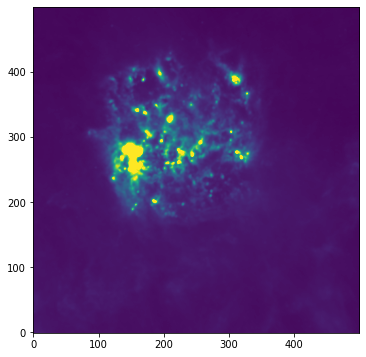

In [8]:
plt.imshow(hdu_iras.data, vmax=100)

We can now use the [reproject_interp()](https://reproject.readthedocs.io/en/latest/api/reproject.reproject_interp.html#reproject.reproject_interp) function to reproject the IRAS map to the same pixel grid as the GAIA source density map:

In [9]:
from reproject import reproject_interp

ImportError: cannot import name 'six' from 'astropy.extern' (c:\users\ssbch\astropy\astropy\extern\__init__.py)

In [ ]:
iras_reprojected, footprint = reproject_interp(hdu_iras, hdu_gaia.header)

In [ ]:
plt.imshow(hdu_gaia.data, vmax = 200)

In [ ]:
plt.imshow(iras_reprojected, vmax=100)

The two maps are now on the exact same pixel grid - you could for example add them together:

In [ ]:
plt.imshow(hdu_gaia.data + iras_reprojected, vmax=300)

The footprint can be used to show the pixels in the output image that had valid pixels in the input image:

In [ ]:
plt.imshow(footprint)

Above we passed HDUs and Header objects to ``reproject_interp``, but it's also possible to pass a tuple of (array, wcs) for the input as well as a WCS for the output and the shape of the output:

In [ ]:
iras_reprojected, footprint = reproject_interp((hdu_iras.data, wcs_iras), wcs_gaia, shape_out=hdu_gaia.data.shape)

## Accuracy

The method of reprojection above relies on interpolation of the input image at the location of the output pixels, and by default uses bilinear interpolation. Other kinds of interpolation are available:

In [ ]:
iras_reprojected, footprint = reproject_interp(hdu_iras, hdu_gaia.header, order='nearest-neighbor')

In [ ]:
iras_reprojected, footprint = reproject_interp(hdu_iras, hdu_gaia.header, order='bicubic')

but in general, using interpolation is more geared towards visualization and plots and is not suitable if you need the reprojected values to be accurate to do e.g. photometry or other analysis – if accuracy is important, then you should consider instead using [reproject_exact()](https://reproject.readthedocs.io/en/latest/api/reproject.reproject_exact.html#reproject.reproject_exact), which uses the same algorithm as the [Montage](http://montage.ipac.caltech.edu/) package, based on determining the exact overlap of input and output pixels. 

In [ ]:
from reproject import reproject_exact

In [ ]:
iras_reprojected_exact, footprint = reproject_exact(hdu_iras, hdu_gaia.header)

In [ ]:
plt.imshow(iras_reprojected_exact - iras_reprojected, vmin=-0.1, vmax=0.1)


<section class="challenge panel panel-success">
<div class="panel-heading">
<h2><span class="fa fa-pencil"></span> Challenge</h2>
</div>


<div class="panel-body">

<ol>
<li>Reproject the GAIA source density map to the WCS of the IRAS map</li>
<li>Make a plot of the resulting image with WCSAxes</li>
<li>If you have FITS images available, try this out with your own data!</li>
</ol>

</div>

</section>


<center><i>This notebook was originally written by <a href="https://aperiosoftware.com/">Aperio Software Ltd</a> and modified by Brigitta Sipőcz. &copy; 2019-2021 and is licensed under a <a href="https://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License (CC BY 4.0)</a></i></center>

![cc](https://mirrors.creativecommons.org/presskit/buttons/88x31/svg/by.svg)